In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, GlobalMaxPooling1D, Dropout
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# CNN_LSTM

### Read Cleaned Data

In [3]:
oba_cleanall = np.load('./TrainData/tweets_oba.npy', allow_pickle=True)
targets_oba = np.load('./TrainData/targets_oba.npy', allow_pickle=True)
rom_cleanall = np.load('./TrainData/tweets_rom.npy', allow_pickle=True)
targets_rom = np.load('./TrainData/targets_rom.npy', allow_pickle=True)
data_all = np.load('./TrainData/data_all.npy', allow_pickle=True)
targets_all = np.load('./TrainData/targets_all.npy', allow_pickle=True)
df_oba = pd.DataFrame({'tweet': oba_cleanall, 'label': targets_oba })
df_rom = pd.DataFrame({'tweet': rom_cleanall, 'label': targets_rom })
df_all = pd.DataFrame({'tweet': data_all, 'label': targets_all})

/usr/local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='label', ylabel='count'>

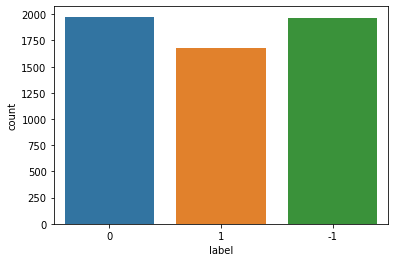

In [4]:
sns.countplot(df_oba['label'])

<AxesSubplot:title={'center':'label = -1'}, xlabel='text_length'>

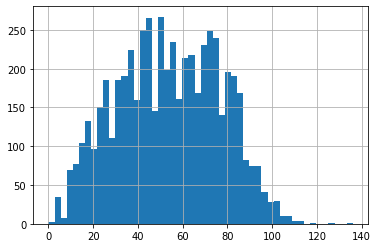

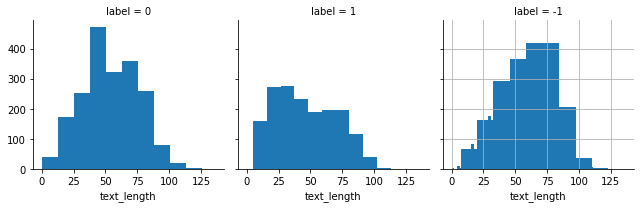

In [5]:
df_oba['text_length'] = df_oba['tweet'].apply(len)
df_oba[['label','text_length','tweet']].head()
df_oba['text_length'].describe()
df_oba['text_length'].hist(bins=50)
g = sns.FacetGrid(df_oba,col='label')
g.map(plt.hist,'text_length')

df_rom['text_length'] = df_rom['tweet'].apply(len)
df_rom[['label','text_length','tweet']].head()
df_rom['text_length'].describe()
df_rom['text_length'].hist(bins=50)
# g = sns.FacetGrid(df_rom,col='label')
# g.map(plt.hist,'text_length')


### Data Preprocessing


In [63]:
seed = 101 # fix random seed for reproducibility
np.random.seed(seed)

# Split Train Test sets
from sklearn.model_selection import train_test_split
def split_data(tweets, labels):
    X_train, X_test, y_train, y_test = train_test_split(tweets, labels,
                                                    test_size=0.2,
                                                    stratify=labels,
                                                    random_state=seed)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df_oba['tweet'], df_oba['label'])
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4499,) (1125,) (4499,) (1125,)


In [64]:
# Tokenize Text
from keras.preprocessing.text import Tokenizer
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

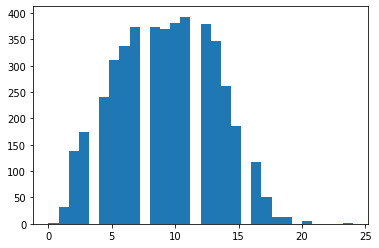

In [65]:
totalNumWords = [len(one_comment) for one_comment in X_train]
plt.hist(totalNumWords,bins = 30)
plt.show()


In [66]:
from keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

# Pad Sequence
max_words = 100
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_test.shape)

# One Hot encoding labels
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
print(y_train.shape,y_test.shape)

(4499, 100) (1125, 100)
(4499, 3) (1125, 3)


#### CNN-LSTM

In [97]:
batch_size = 128
epochs = 5
num_classes = 3

def get_model(max_features, embed_dim):
    np.random.seed(seed)
    K.clear_session()
    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=X_train.shape[1]))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [98]:
def model_train(model):
    # train the model
    model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                          epochs=epochs, batch_size=batch_size, verbose=2)
    print(model_history.history)
    # plot train history
    plot_model_history(model_history)

In [11]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [32]:
def model_evaluate(model):
    # predict class with test set
    y_pred_test =  model.predict_classes(X_test, batch_size=batch_size, verbose=0)
    print('Accuracy:\t{:0.1f}%'.format(accuracy_score(np.argmax(y_test,axis=1),y_pred_test)*100))

    #classification report
    print('\n')
    print(classification_report(np.argmax(y_test,axis=1), y_pred_test))

    #confusion matrix
    confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 32)            9632      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 3)                 3

<ipython-input-67-488f151b518c>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-67-488f151b518c>:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


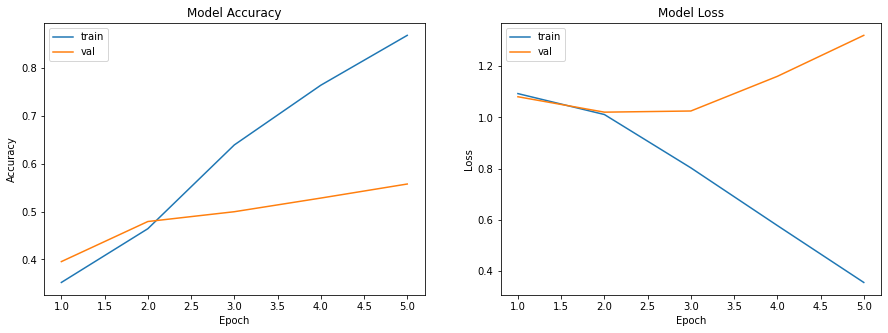

In [69]:
# train the model
max_features = 20000
embed_dim = 100
model = get_model(max_features, embed_dim)
model_train(model)

Accuracy:	55.7%


              precision    recall  f1-score   support

           0       0.52      0.47      0.50       395
           1       0.54      0.65      0.59       336
           2       0.61      0.57      0.59       394

    accuracy                           0.56      1125
   macro avg       0.56      0.56      0.56      1125
weighted avg       0.56      0.56      0.56      1125



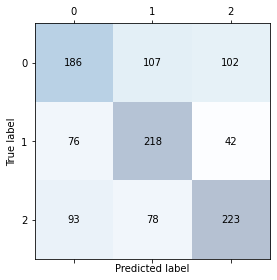

In [70]:
model_evaluate()

## CNN + LSTM _ Model2

In [70]:
def count_tfidf(X_train, X_test):
    
    max_features = 20000
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(X_train))
    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)
    # Pad Sequence
    max_words = 100
    X_train = sequence.pad_sequences(X_train, maxlen=max_words)
    X_test = sequence.pad_sequences(X_test, maxlen=max_words)
    print(X_train.shape, X_test.shape)
    
    return X_train, X_test

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 99, 100)           20100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 99, 100)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 10)                4440      
_________________________________________________________________
dense_29 (Dense)             (None, 256)               2816      
_________________________________________________________________
dense_30 (Dense)             (None, 3)                 771       
Total params: 2,028,127
Trainable params: 2,028,127
Non-trainable params: 0
___________________________________________

<ipython-input-11-21a1cb06bcb9>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-11-21a1cb06bcb9>:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


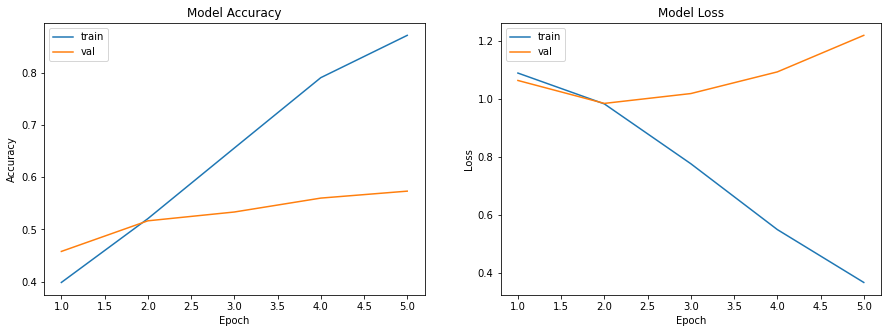

In [67]:
def get_model2():
    e = Embedding(20000, 100, input_length=100)
    model = Sequential()
    model.add(e)
    model.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
    #model.add(GlobalMaxPooling1D())
    model.add(Dropout(0.3))
    model.add(LSTM(10))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(3, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

model2 = get_model2()
model_train(model2)

Accuracy:	57.3%


              precision    recall  f1-score   support

           0       0.54      0.45      0.49       395
           1       0.60      0.66      0.63       336
           2       0.58      0.62      0.60       394

    accuracy                           0.57      1125
   macro avg       0.57      0.58      0.57      1125
weighted avg       0.57      0.57      0.57      1125



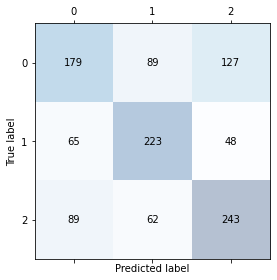

In [68]:
model_evaluate(model2)

In [109]:
## With Obama data
X_train, X_test, y_train, y_test = split_data(df_oba['tweet'], df_oba['label'])
X_train, X_test = count_tfidf(X_train, X_test)

# One Hot encoding labels
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
print(y_train.shape,y_test.shape)

(4499, 100) (1125, 100)
(4499, 3) (1125, 3)


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_34 (Embedding)     (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 99, 100)           20100     
_________________________________________________________________
dropout_21 (Dropout)         (None, 99, 100)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 10)                4440      
_________________________________________________________________
dense_57 (Dense)             (None, 256)               2816      
_________________________________________________________________
dense_58 (Dense)             (None, 3)                 771       
Total params: 2,028,127
Trainable params: 2,028,127
Non-trainable params: 0
___________________________________________

<ipython-input-11-21a1cb06bcb9>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-11-21a1cb06bcb9>:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


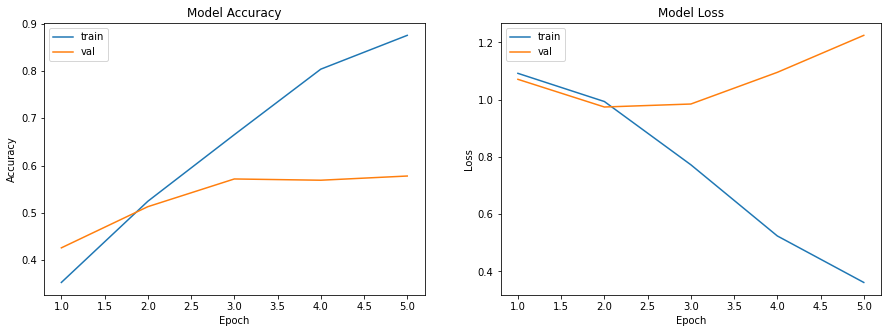

In [110]:
model_oba = get_model2()
model_train(model_oba)

Accuracy:	57.8%


              precision    recall  f1-score   support

           0       0.54      0.48      0.51       395
           1       0.60      0.64      0.62       336
           2       0.58      0.62      0.60       394

    accuracy                           0.58      1125
   macro avg       0.58      0.58      0.58      1125
weighted avg       0.58      0.58      0.58      1125



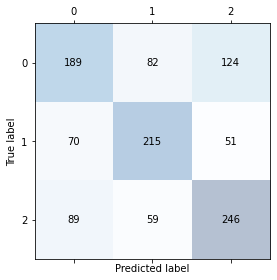

In [111]:
model_evaluate(model_oba)

In [117]:
## With Romney data
X_train, X_test, y_train, y_test = split_data(df_rom['tweet'], df_rom['label'])
X_train, X_test = count_tfidf(X_train, X_test)

# One Hot encoding labels
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
print(y_train.shape,y_test.shape)

(4518, 100) (1130, 100)
(4518, 3) (1130, 3)


Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 99, 100)           20100     
_________________________________________________________________
dropout_24 (Dropout)         (None, 99, 100)           0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 10)                4440      
_________________________________________________________________
dense_63 (Dense)             (None, 256)               2816      
_________________________________________________________________
dense_64 (Dense)             (None, 3)                 771       
Total params: 2,028,127
Trainable params: 2,028,127
Non-trainable params: 0
___________________________________________

<ipython-input-11-21a1cb06bcb9>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-11-21a1cb06bcb9>:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


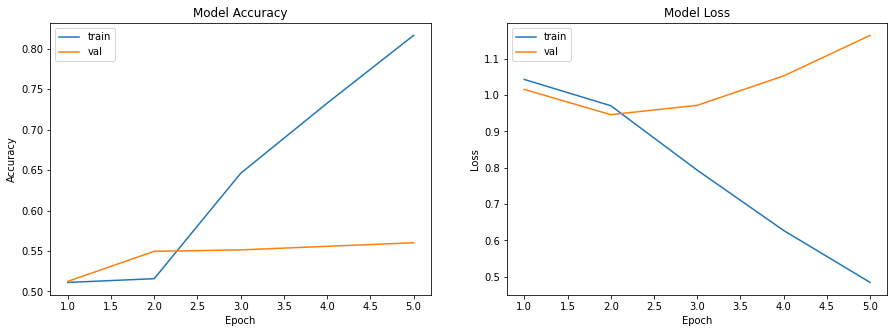

In [118]:
model_rom = get_model2()
model_train(model_rom)

Accuracy:	56.0%


              precision    recall  f1-score   support

           0       0.42      0.32      0.37       336
           1       0.45      0.54      0.49       215
           2       0.66      0.70      0.68       579

    accuracy                           0.56      1130
   macro avg       0.51      0.52      0.51      1130
weighted avg       0.55      0.56      0.55      1130



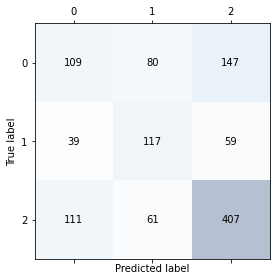

In [119]:
model_evaluate(model_rom)

In [120]:
## With all dataset
X_train, X_test, y_train, y_test = split_data(df_all['tweet'], df_all['label'])
X_train, X_test = count_tfidf(X_train, X_test)

# One Hot encoding labels
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)
print(y_train.shape,y_test.shape)

(9017, 100) (2255, 100)
(9017, 3) (2255, 3)


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_39 (Embedding)     (None, 100, 100)          2000000   
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 99, 100)           20100     
_________________________________________________________________
dropout_26 (Dropout)         (None, 99, 100)           0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 10)                4440      
_________________________________________________________________
dense_67 (Dense)             (None, 256)               2816      
_________________________________________________________________
dense_68 (Dense)             (None, 3)                 771       
Total params: 2,028,127
Trainable params: 2,028,127
Non-trainable params: 0
___________________________________________

<ipython-input-11-21a1cb06bcb9>:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
<ipython-input-11-21a1cb06bcb9>:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)


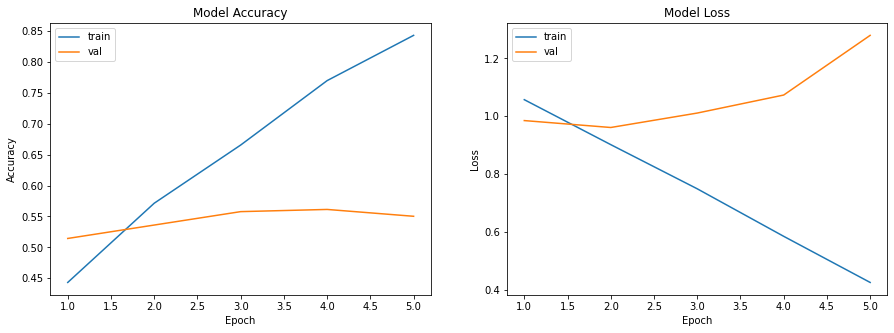

In [123]:
model_all = get_model2()
model_train(model_all)

Accuracy:	55.0%


              precision    recall  f1-score   support

           0       0.47      0.48      0.48       732
           1       0.55      0.39      0.46       551
           2       0.60      0.69      0.64       972

    accuracy                           0.55      2255
   macro avg       0.54      0.52      0.53      2255
weighted avg       0.55      0.55      0.54      2255



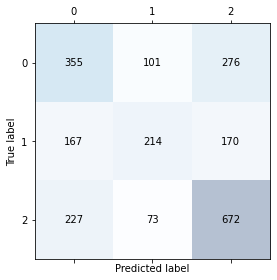

In [122]:
model_evaluate(model_all)

In [128]:
# Test how to_categorical convert labels
X_train, X_test, y_train, y_test = split_data(df_all['tweet'], df_all['label'])
y_train[:10]

10350     0
7768      0
3005     -1
10526    -1
9433     -1
1791      0
3151     -1
5391     -1
9849      0
9915     -1
Name: label, dtype: object

In [131]:
a = to_categorical(y_train[:10], 3)
a

array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)